<a href="https://colab.research.google.com/github/AnshDhingraAD/traffic_detection/blob/main/final2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-12-27 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Enter the image path for Lane 1: /content/WhatsApp Image 2024-12-27 at 11.35.44 AM (1).jpeg
Enter the image path for Lane 2: /content/WhatsApp Image 2024-12-27 at 11.35.44 AM.jpeg
Enter the image path for Lane 3: /content/WhatsApp Image 2024-12-27 at 11.35.46 AM.jpeg
Enter the image path for Lane 4: /content/a-highway-in-india-with-a-tata-truck-and-bus-ABWAKJ.jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Traffic Light Results (Sorted by Priority):

Lane 3: GREEN for 39.20 seconds
Displaying results for Lane 3:


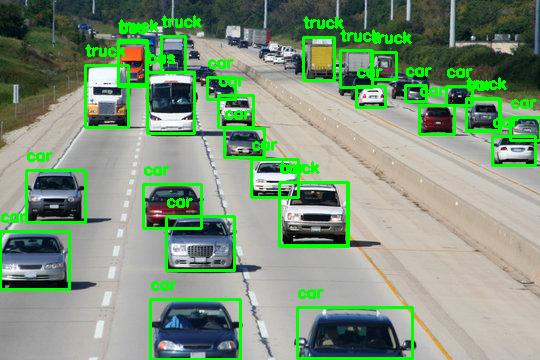

Lanes held RED while Lane 3 is GREEN:
  Lane 1: RED
  Lane 2: RED
  Lane 4: RED


Lane 2: GREEN for 34.34 seconds
Displaying results for Lane 2:


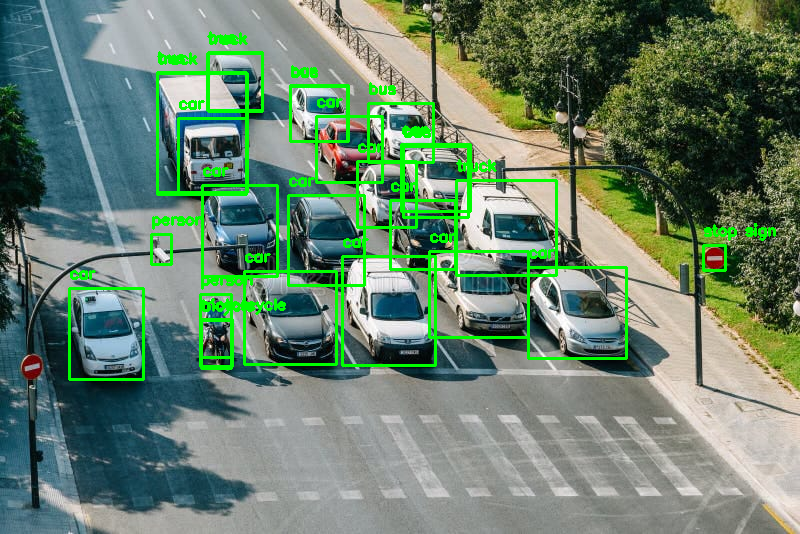

Lanes held RED while Lane 2 is GREEN:
  Lane 1: RED
  Lane 3: RED
  Lane 4: RED


Lane 1: GREEN for 17.02 seconds
Displaying results for Lane 1:


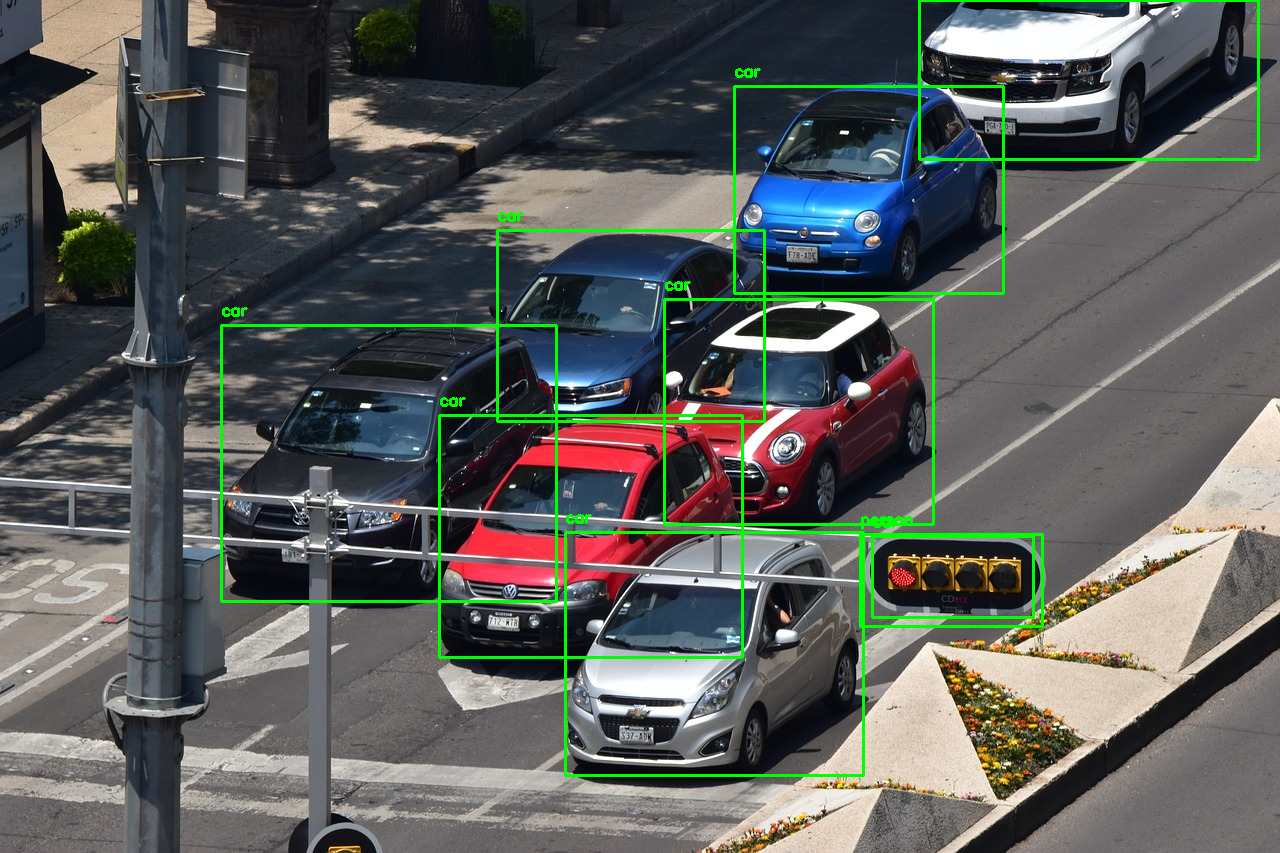

Lanes held RED while Lane 1 is GREEN:
  Lane 2: RED
  Lane 3: RED
  Lane 4: RED


Lane 4: GREEN for 15.00 seconds
Displaying results for Lane 4:


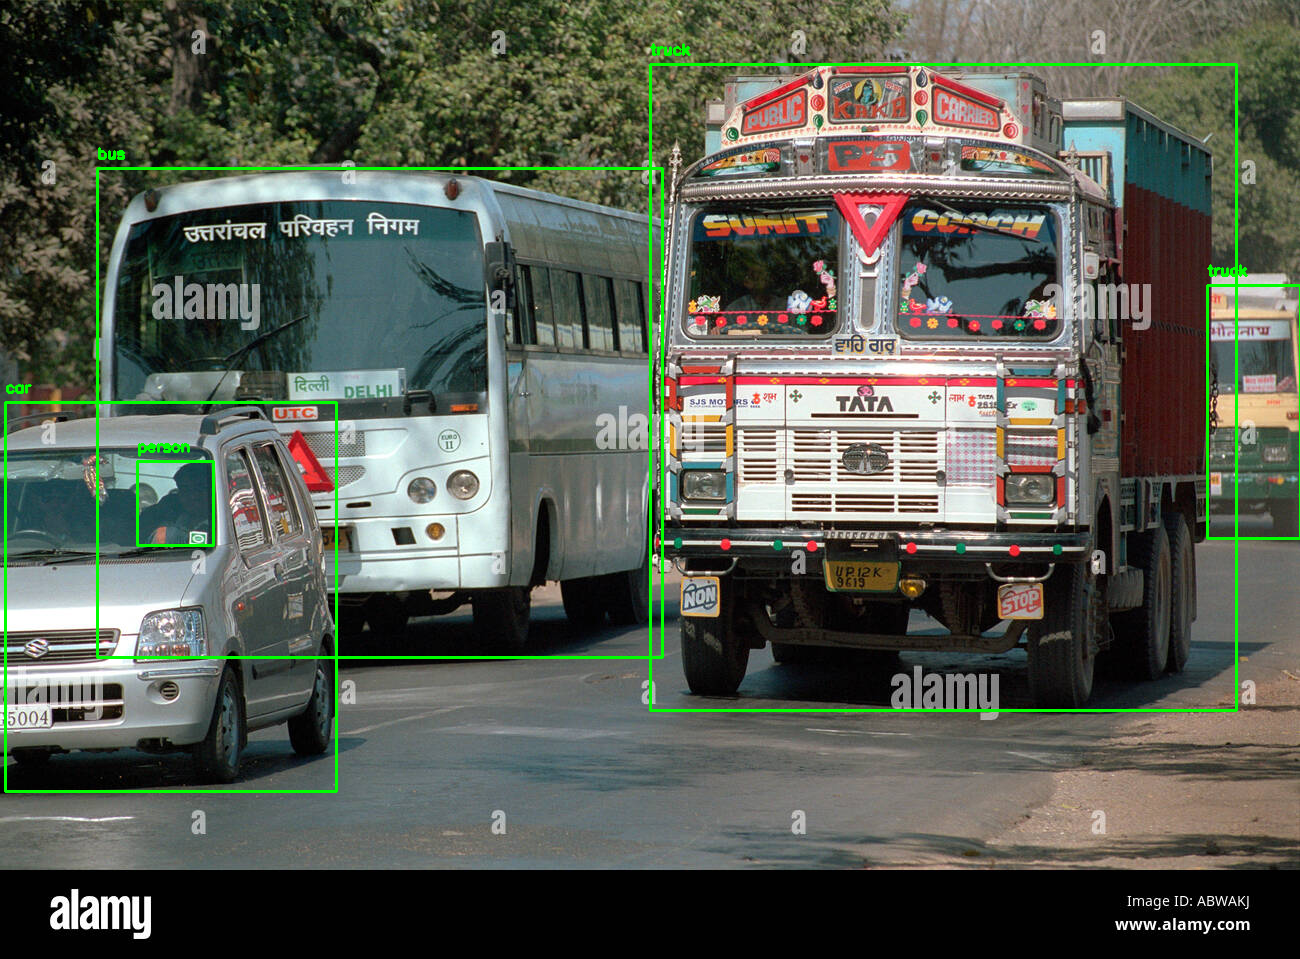

Lanes held RED while Lane 4 is GREEN:
  Lane 1: RED
  Lane 2: RED
  Lane 3: RED




In [8]:
import torch
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Constants
k = 10  # Scaling factor for queue length
carWeight = 1
truckWeight = 3
busWeight = 2.75
bikeWeight = 0.65
maxGreenDuration = 120  # Maximum green light duration (seconds)
baseDuration = 15  # Minimum green light duration (seconds)
w1 = 0.6  # Weight for queue duration
w2 = 0.4  # Weight for vehicle duration

def process_image(image_path):
    """Process an image and return vehicle counts, emergency status, and queue length."""
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not read the image at {image_path}.")
        return None, None

    # Perform inference
    results = model(frame)
    df = results.pandas().xyxy[0]

    # Initialize counters
    car_count = truck_count = bike_count = bus_count = emergency_count = queue_length = 0

    for _, row in df.iterrows():
        x1, y1, x2, y2, _, cls = row[['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']].values
        vehicle_type = model.names[int(cls)]

        # Update counts based on vehicle type
        if vehicle_type == 'car':
            car_count += 1
        elif vehicle_type == 'truck':
            truck_count += 1
        elif vehicle_type == 'bus':
            bus_count += 1
        elif vehicle_type == 'motorcycle':
            bike_count += 1
        elif vehicle_type in ['ambulance', 'fire truck']:
            emergency_count += 1

        # Increment queue length for each detection
        queue_length += 1

        # Draw bounding box and label
        label = vehicle_type
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return frame, (car_count, truck_count, bike_count, bus_count, emergency_count, queue_length)

def calculate_aqi_impact(aqi):
    """Adjust the green light duration based on AQI."""
    if aqi < 50:
        return 0.8  # Reduce by 20%
    elif 50 <= aqi <= 100:
        return 0.9  # Reduce by 10%
    elif 101 <= aqi <= 200:
        return 1.0  # No change
    elif 201 <= aqi <= 300:
        return 1.2  # Increase by 20%
    else:  # AQI > 300
        return 1.5  # Increase by 50%

def calculate_green_light_duration(queue_length, car_count, truck_count, bus_count, bike_count, aqi):
    """Calculate the green light duration for a lane."""
    queue_duration = k * math.log(queue_length + 1)
    vehicle_duration = (car_count * carWeight) + (truck_count * truckWeight) + (bus_count * busWeight) + (bike_count * bikeWeight)
    aqi_impact = calculate_aqi_impact(aqi)
    weighted_duration = (w1 * queue_duration + w2 * vehicle_duration) * aqi_impact
    return min(maxGreenDuration, max(baseDuration, weighted_duration))

# Main Program
lanes_data = {}  # Store lane durations and other info
aqi = 187  # Example AQI value

# Take images for all lanes at once
lane_images = {}
for lane in range(1, 5):
    image_path = input(f"Enter the image path for Lane {lane}: ")
    lane_images[lane] = image_path

# Process all lanes
for lane, image_path in lane_images.items():
    try:
        frame, result = process_image(image_path)
        if result:
            car, truck, bike, bus, emergency, queue = result
            green_duration = calculate_green_light_duration(queue, car, truck, bus, bike, aqi)
            lanes_data[lane] = {
                "green_duration": green_duration,
                "queue_length": queue,
                "emergency": emergency > 0,  # True if there is at least one emergency vehicle
                "vehicle_counts": {
                    "car": car,
                    "truck": truck,
                    "bike": bike,
                    "bus": bus,
                    "emergency": emergency
                },
                "output_image": frame
            }
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Sort lanes by green light duration in descending order
sorted_lanes = sorted(lanes_data.items(), key=lambda x: x[1]["green_duration"], reverse=True)

# Display Results
print("\nTraffic Light Results (Sorted by Priority):\n")
for lane, data in sorted_lanes:
    green_duration = data["green_duration"]
    print(f"Lane {lane}: GREEN for {green_duration:.2f} seconds")
    if data["output_image"] is not None:
        print(f"Displaying results for Lane {lane}:")
        cv2_imshow(data["output_image"])

    # Show other lanes held red
    print(f"Lanes held RED while Lane {lane} is GREEN:")
    for other_lane in lane_images.keys():
        if other_lane != lane:
            print(f"  Lane {other_lane}: RED")

    print("\n" + "="*50 + "\n")  # Separator for clarity
